In [1]:
import galprime
galprime.plotting.pyplot_style()
cmap = galprime.plotting.lavender_cmap()

from astropy.io import fits
from astropy.table import Table
from astropy.modeling.models import Sersic2D

from astropy.visualization import ZScaleInterval

import configobj

import numpy as np

from scipy.signal import convolve2d
from scipy.special import gamma

from matplotlib import pyplot as plt

from astropy.visualization import ZScaleInterval

from photutils.background import Background2D

from concurrent.futures import TimeoutError
from pebble import ProcessPool

In [13]:

class GPrime:

    def __init__(self, config_filename, verbose=True, **kwargs):
        self.config = galprime.read_config_file(config_filename)

        self.run_id = kwargs.get("run_id", np.random.randint(1e3, 1e4))

        c = self.config

        # Load in all necessary files (backgrounds, psfs, catalogues, etc)
        self.bgs = galprime.Cutouts.from_file(f'{c["FILE_DIR"]}{c["FILES"]["BACKGROUNDS"]}', verbose=verbose)
        
        self.psfs = galprime.Cutouts.from_file(f'{c["FILE_DIR"]}{c["FILES"]["PSFS"]}', verbose=verbose)
        self.psfs.get_ra_dec(ra_key=c["PSFS"]["PSF_RA"], dec_key=c["PSFS"]["PSF_DEC"])
        
        self.table = Table.read(f'{c["FILE_DIR"]}{c["FILES"]["CATALOGUE"]}')
        self.table = galprime.trim_table(self.table, c)
        
        if c["FILES"]["MAG_CATALOGUE"] is not None:
            self.mags = Table.read(f'{c["FILE_DIR"]}{c["FILES"]["MAG_CATALOGUE"]}')
            self.mag_kde = galprime.object_kde(self.mags[c["KEYS"]["MAG"]])
        else:
            self.mags = self.mag_kde = None


    def run(self, max_bins=None, verbose=True):
        c = self.config

        binlist = galprime.bin_catalogue(self.table, bin_params=c["BINS"], params=c["KEYS"], verbose=True)
        max_bins = len(binlist.bins) if max_bins is None else min(max_bins, len(binlist.bins))

        for i in range(max_bins):
            b = binlist.bins[i]
            containers = self.process_bin(b)

        return containers


    def process_bin(self, bin):
        c = self.config
        kde = bin.to_kde()
        models = galprime.gen_models(c, kde, mag_kde=self.mag_kde, n_models=5)
        containers = gen_containers(c, models, self.psfs, self.bgs)
    
        TIMEOUT = c["TIME_LIMIT"]

        for container in containers:
            container.run()
        
        return containers

        # with ProcessPool(max_workers=c["NTHREADS"]) as pool:
        #     for container in containers:
        #         future = pool.schedule(container.run, timeout=TIMEOUT)
        #         future.add_done_callback(task_done)

        #     pool.close()
        #     pool.join()
        
        # for container in containers:
        #     print(container.stop_code)


class GPrimeContainer:
    def __init__(self, config, model, psf=None, bg=None, metadata={}, stop_code=0):
        self.id = np.random.randint(1e11, 1e12)
        self.config = config
        self.model = model
        self.convolved_model = self.bgadded = self.bgsub = None
        self.bgadded_masked, self.bgsub_masked = None, None

        self.model_profile = self.bgadded_profile = self.bgsub_profile = None
        self.psf = psf
        self.bg = bg
        self.metadata = metadata
        self.stop_code = stop_code
    
    def run(self):

        self.convolved_model = convolve2d(self.model, self.psf, mode='same')

        self.bgadded = self.convolved_model + self.bg

        self.source_mask, mask_metadata = galprime.gen_mask(self.bgadded, self.config)
        
        self.stop_code=1


    def plot(self, outdir="", **kwargs):
        
        fig, ax = plt.subplots(2, 4, figsize=(10, 5), facecolor="white")

        lims = ZScaleInterval().get_limits(self.bg)

        ax[0][0].imshow(self.model, cmap=kwargs.get("cmap", "Greys"), vmin=lims[0], vmax=lims[1])
        ax[0][1].imshow(self.bg, cmap=kwargs.get("cmap", "Greys"), vmin=lims[0], vmax=lims[1])
        ax[0][2].imshow(self.bgadded, cmap=kwargs.get("cmap", "Greys"), vmin=lims[0], vmax=lims[1])
        # ax[0][1].imshow(self.bg, cmap=kwargs.get("cmap", "Greys"), vmin=lims[0], vmax=lims[1])

        ax[1][0].imshow(self.source_mask, cmap=kwargs.get("cmap", "Greys"))
        

        for axis in ax.flatten():
            axis.set(xticks=[], yticks=[])

        plt.tight_layout()
        plt.savefig(f"{outdir}_{self.id}.pdf", dpi=kwargs.get("dpi", 150))


def gen_containers(config, models, psfs, bgs):

    containers = []
    for model in models.cutouts:
        psf_index = np.random.randint(len(psfs.cutouts))
        bg_index = np.random.randint(len(bgs.cutouts))
        containers.append(GPrimeContainer(config, 
                                          np.copy(model), 
                                          psf = np.copy(psfs.cutouts[psf_index]), 
                                          bg = np.copy(bgs.cutouts[bg_index])))
    return containers


test = GPrime("myconfig.gprime", verbose=True)
containers = test.run(max_bins=1)

Loaded 50 cutouts from ../pdata/cutouts_i.fits with shape (451, 451)
Loaded 5800 cutouts from ../pdata/i_psfs.fits with shape (41, 41)
Pruned 0 bins with fewer than 10 objects.


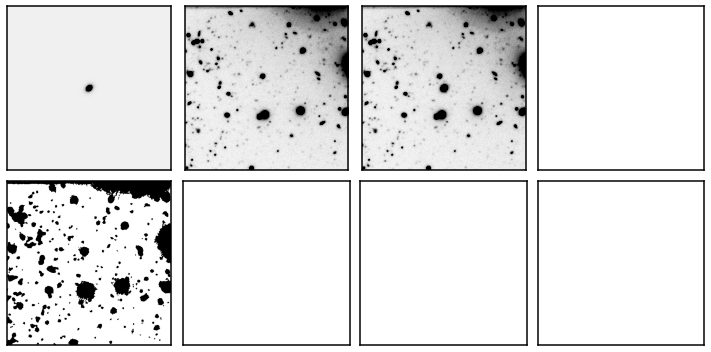

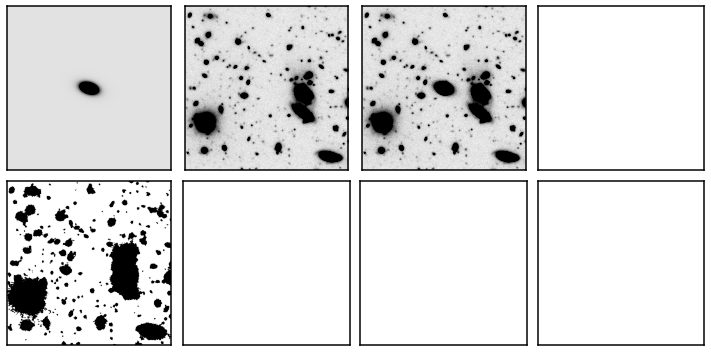

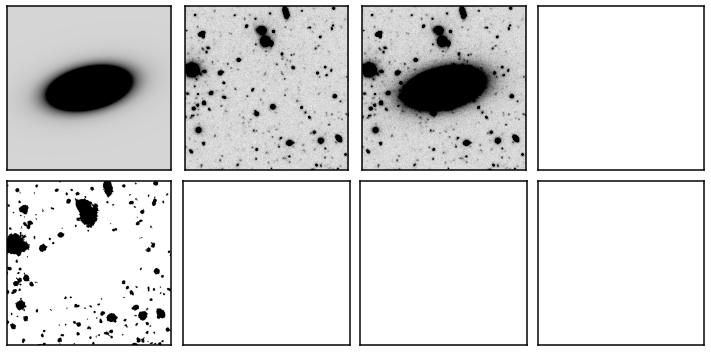

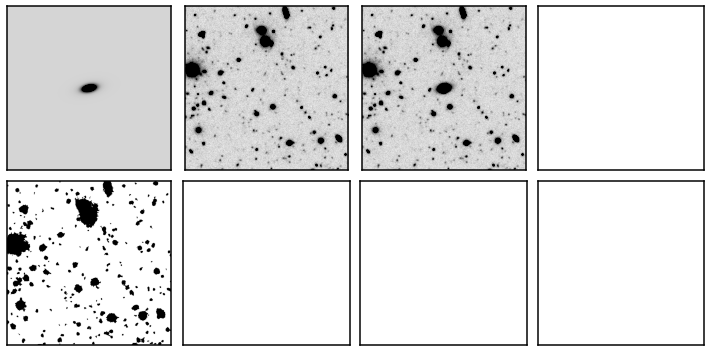

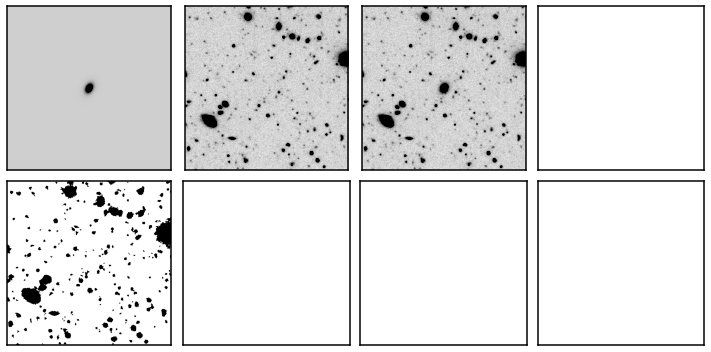

In [14]:
for container in containers:
    container.plot(outdir="temp/")

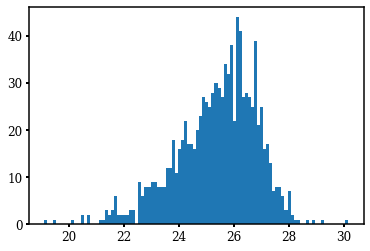

NameError: name 'b_test' is not defined

In [ ]:
c = galprime.read_config_file("myconfig.gprime")

if c["FILES"]["MAG_CATALOGUE"] is not None:
    mags = Table.read(f'{c["FILE_DIR"]}{c["FILES"]["MAG_CATALOGUE"]}')
    mags = mags[c["KEYS"]["MAG"]]
    mags = mags[mags > 0]

    mag_kde = galprime.object_kde(mags)
else:
    mags = mag_kde = None

mags_test = mag_kde.resample(size=1000).T

plt.hist(mags_test.flatten(), bins=100)
plt.show()

models = galprime.gen_models(test.config, b_test.to_kde(), n_models=50, mag_kde=mag_kde)
bgs = galprime.Cutouts.from_file(c["FILE_DIR"] + c["FILES"]["BACKGROUNDS"], verbose=True)

for i, mod in enumerate(models.cutouts):
    models.cutouts[i] += bgs.sample()[0]

galprime.plotting.show_cutouts(models, cmap=cmap, method="log", vmin=-2, vmax=3)
plt.show()